<a href="https://colab.research.google.com/github/fambargh/SAMPLE/blob/master/fam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classify pigmented skin lesions dermatoscopic images from HAM10k https://www.nature.com/articles/sdata2018161 into 7 diagnosis


In [86]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
s='/content/drive/My Drive/me/train'
d='/content/drive/My Drive/me/tet'
f='/content/drive/My Drive/me/validation'

In [3]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.python.keras.applications import ResNet50

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import ResNet50

import os
#print(os.listdir("../input"))

Using TensorFlow backend.


In [4]:
PATH = "/content/drive/My Drive/me/"
print(os.listdir(PATH))

['validation', 'train', 'test']


In [5]:
# Check content of the dirs

PATHtrain = PATH + 'train/'
print(len(os.listdir(PATHtrain)), " TRAIN Directories of photos")
Labels = os.listdir(PATHtrain)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtrain + label +'/')))
    sig = sig + len(os.listdir(PATHtrain + label +'/'))

print("Total TRAIN photos ", sig)
print("_"*50)

PATHvalid = PATH + 'validation/'
print(len(os.listdir(PATHvalid)), " VALID Directories of photos")
Labels = os.listdir(PATHvalid)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHvalid + label +'/')))
    sig = sig + len(os.listdir(PATHvalid + label +'/'))

print("Total Validation photos ", sig)
print("_"*50)

PATHtest = PATH + 'test/'
print(len(os.listdir(PATHtest)), " TEST Directories of photos")
Labels = os.listdir(PATHtest)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtest + label +'/')))
    sig = sig + len(os.listdir(PATHtest + label +'/'))

print("Total Testing photos ", sig)
print("_"*50)

2  TRAIN Directories of photos
Normal 199
glaucoma 99
Total TRAIN photos  298
__________________________________________________
2  VALID Directories of photos
Normal 24
glaucoma 50
Total Validation photos  74
__________________________________________________
2  TEST Directories of photos
Normal 32
glaucoma 51
Total Testing photos  83
__________________________________________________


TRAIN  glaucoma  photo number  7


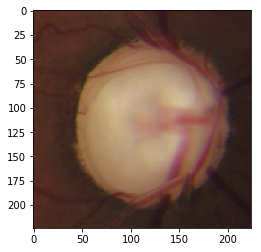

VALID  glaucoma  photo number  7


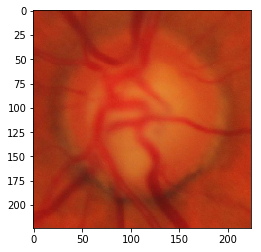

TEST  glaucoma  photo number  7


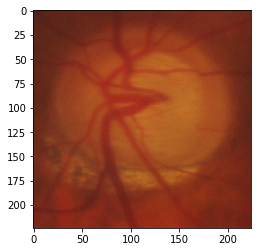

In [6]:
# Check the photos and their labels 

TestNum = 7
diag = 'glaucoma'

image_dir = PATHtrain +'/'+diag+'/'
img_name = os.listdir(image_dir)[TestNum]
img_path = image_dir+str(img_name)
img = image.load_img(img_path, target_size=(224, 224))
imgplot = plt.imshow(img)
print("TRAIN ",diag," photo number ", TestNum)
plt.show()

image_dir = PATHvalid +'/'+diag+'/'
img_name = os.listdir(image_dir)[TestNum]
img_path = image_dir+str(img_name)
img = image.load_img(img_path, target_size=(224, 224))
imgplot = plt.imshow(img)
print("VALID ",diag," photo number ", TestNum)
plt.show()

image_dir = PATHtest +'/'+diag+'/'
img_name = os.listdir(image_dir)[TestNum]
img_path = image_dir+str(img_name)
img = image.load_img(img_path, target_size=(224, 224))
imgplot = plt.imshow(img)
print("TEST ",diag," photo number ", TestNum)
plt.show()


In [7]:
# Convoluted Base MODEL

conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

print(conv_base.summary())

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

In [8]:
# MODEL

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total

In [9]:
# Make the conv_base NOT trainable:

for layer in conv_base.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [10]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_1 False
5 pool1_pad False
6 max_pooling2d_1 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_2 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_3 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_1 False
18 activation_4 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_5 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_6 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_2 False
28 activation_7 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_8 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_9 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_3 False
38 activation_10 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_11 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_12 False
45 res3a_branch2c False

In [11]:
# Compile frozen conv_base + my top layer

model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")
print(model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
model compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total para

In [12]:
# Prep the Train Valid and Test directories for the generator

train_dir = PATHtrain
validation_dir = PATHvalid
test_dir = PATHtest
batch_size = 20
target_size=(224, 224)

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=batch_size)

Found 298 images belonging to 2 classes.
Found 74 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [13]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Normal': 0, 'glaucoma': 1}
{'Normal': 0, 'glaucoma': 1}
{'Normal': 0, 'glaucoma': 1}


It’s necessary to freeze the convolution base of the conv base in order to
be able to train a randomly initialized classifier on top. For the same reason, it’s only
possible to fine-tune the top layers of the convolutional base **once the classifier on top
has already been trained**. If the classifier isn’t already trained, then the error signal
propagating through the network during training will be too large, and the representations
previously learned by the layers being fine-tuned will be destroyed

**Below, first train with no limit to lr - with conv_base frozen - only  my top layers**

**Then, unfreeze last model conv block , recompile and train all with LOW lr=1e-5**

In [14]:
# Short training ONLY my top layers 
#... so the conv_base weights will not be destroyed by the random intialization of the new weights

history = model.fit_generator(train_generator,
                              epochs=3,
                              steps_per_epoch = 10682 // batch_size,
                              validation_data = validation_generator,
                              validation_steps = 3562 // batch_size)

Epoch 1/3
534/534 [==============================] - 368s 689ms/step - loss: 1.6249 - acc: 0.7846 - val_loss: 1.3030 - val_acc: 0.6816
Epoch 2/3
534/534 [==============================] - 270s 505ms/step - loss: 0.7636 - acc: 0.8602 - val_loss: 1.2038 - val_acc: 0.6965
Epoch 3/3
534/534 [==============================] - 269s 503ms/step - loss: 0.6805 - acc: 0.8787 - val_loss: 1.6206 - val_acc: 0.6478


In [15]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')

Last block of the conv_base is now trainable


In [16]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_1 False
5 pool1_pad False
6 max_pooling2d_1 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_2 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_3 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_1 False
18 activation_4 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_5 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_6 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_2 False
28 activation_7 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_8 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_9 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_3 False
38 activation_10 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_11 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_12 False
45 res3a_branch2c False

In [17]:
# Compile frozen conv_base + UNfrozen top block + my top layer ... SLOW LR

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")
print(model.summary())

model compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 10,888,386
Non-trainable params: 19,122,048
__________________

In [18]:
# Long training with fine tuning

history = model.fit_generator(train_generator,
                              epochs=5,
                              steps_per_epoch = 10682 // batch_size,
                              validation_data = validation_generator,
                              validation_steps = 3562 // batch_size)

Epoch 1/5
534/534 [==============================] - 279s 522ms/step - loss: 0.5684 - acc: 0.8866 - val_loss: 1.5451 - val_acc: 0.6754
Epoch 2/5
534/534 [==============================] - 273s 511ms/step - loss: 0.5053 - acc: 0.9030 - val_loss: 1.6125 - val_acc: 0.6626
Epoch 3/5
534/534 [==============================] - 272s 509ms/step - loss: 0.4637 - acc: 0.9095 - val_loss: 1.7061 - val_acc: 0.6484
Epoch 4/5
534/534 [==============================] - 275s 516ms/step - loss: 0.4384 - acc: 0.9186 - val_loss: 1.7510 - val_acc: 0.6626
Epoch 5/5
534/534 [==============================] - 275s 514ms/step - loss: 0.4173 - acc: 0.9238 - val_loss: 1.7093 - val_acc: 0.6620


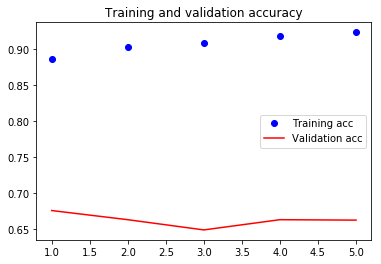

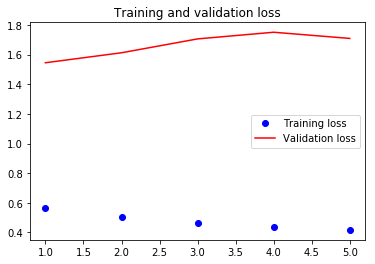

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps= 3561 // batch_size, verbose=1)
print('test acc:', test_acc)

178/178 [==============================] - 88s 495ms/step
test acc: 0.6927487368828933


In [25]:
from keras.models import load_model
# SAVE or LOAD model (Keras - all batteries included: architecture, weights, optimizer, last status in training, etc.)
# YOU supply this model.h5 file from previous training session(s) - expected as a data source by Kaggle

# SAVE model
model.save('MelanomaResNet50FineTune.h5')
print("MelanomaResNet50FineTune.h5 was saved")

# LOAD model
#del model
#model = load_model('../input/weather-v9/modelWeatherV10.h5')
#print("modelWeatherV10.h5 was loaded")

MelanomaResNet50FineTune.h5 was saved


In [0]:
g='/content/drive/My Drive/Untitled folder'

In [0]:
model = load_model('MelanomaResNet50FineTune.h5')

In [55]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10
generator = datagen.flow_from_directory(g,target_size=(224, 224),batch_size=batch_size,class_mode='binary')
features_batch = model.predict(generator)

Found 9 images belonging to 1 classes.


In [56]:
print(features_batch.shape)

(9, 2)


In [0]:
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [0]:
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [0]:
filenames='/content/drive/My Drive/Untitled folder/Untitled folder'

In [0]:
from numpy import zeros
from numpy import asarray
labels = zeros(9,)
#for filename in filenames:
  #categories.append(1)
        
#labels=asarray(categories)

In [95]:
print(labels.shape)

(9,)


In [0]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}


In [0]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [0]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_batch)

In [63]:
pca_result.shape

(9, 2)

In [0]:
tsne = TSNE(n_components=2, perplexity=40.0)

In [0]:
tsne_result = tsne.fit_transform(pca_result)


In [0]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)


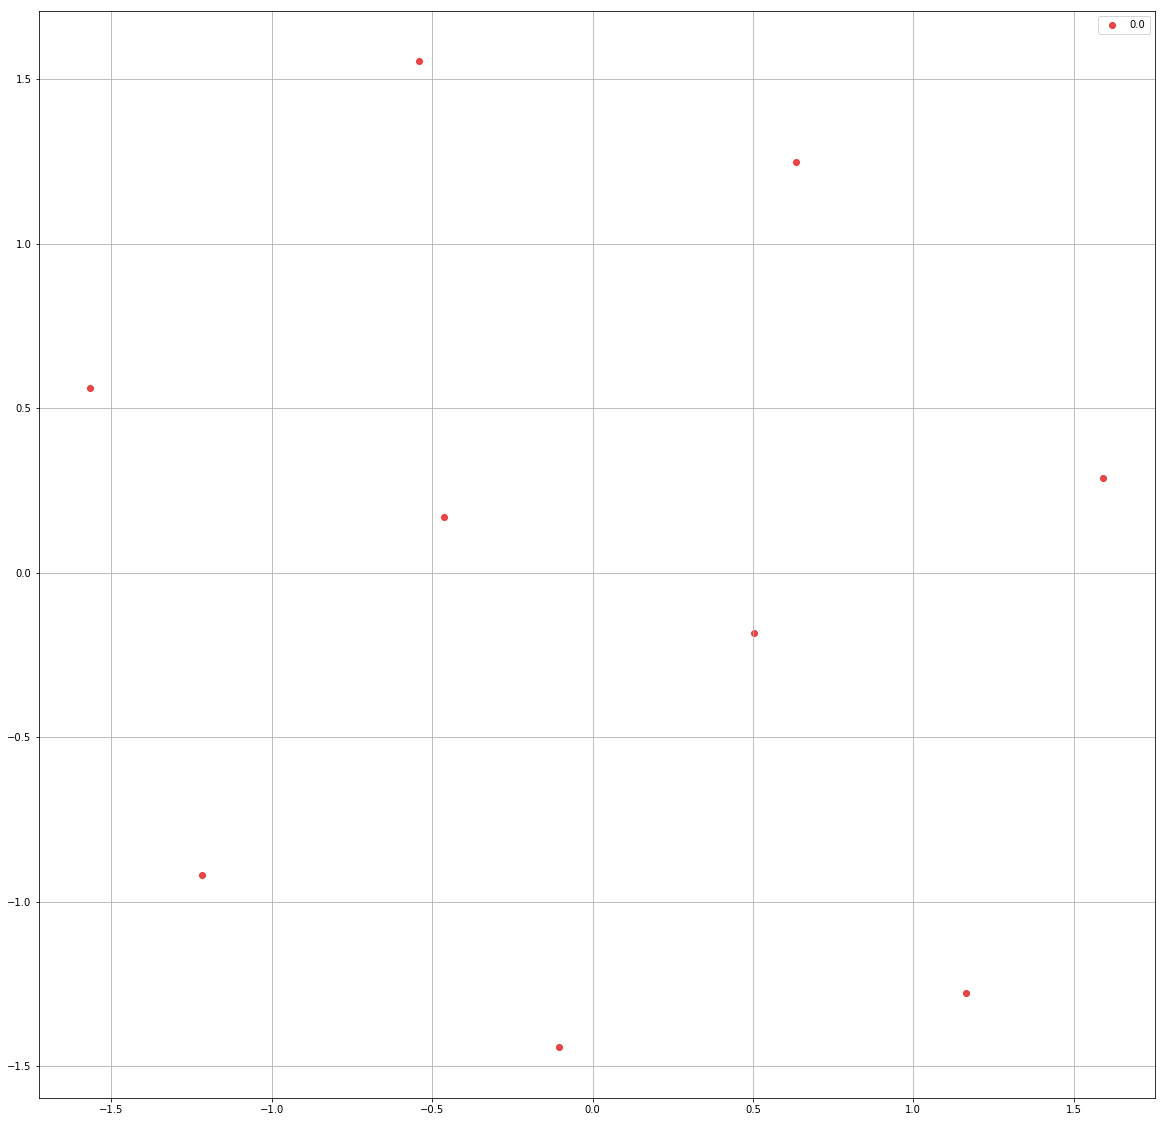

In [112]:
visualize_scatter(tsne_result_scaled, labels)


In [0]:
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

(-2.5, 2.5)

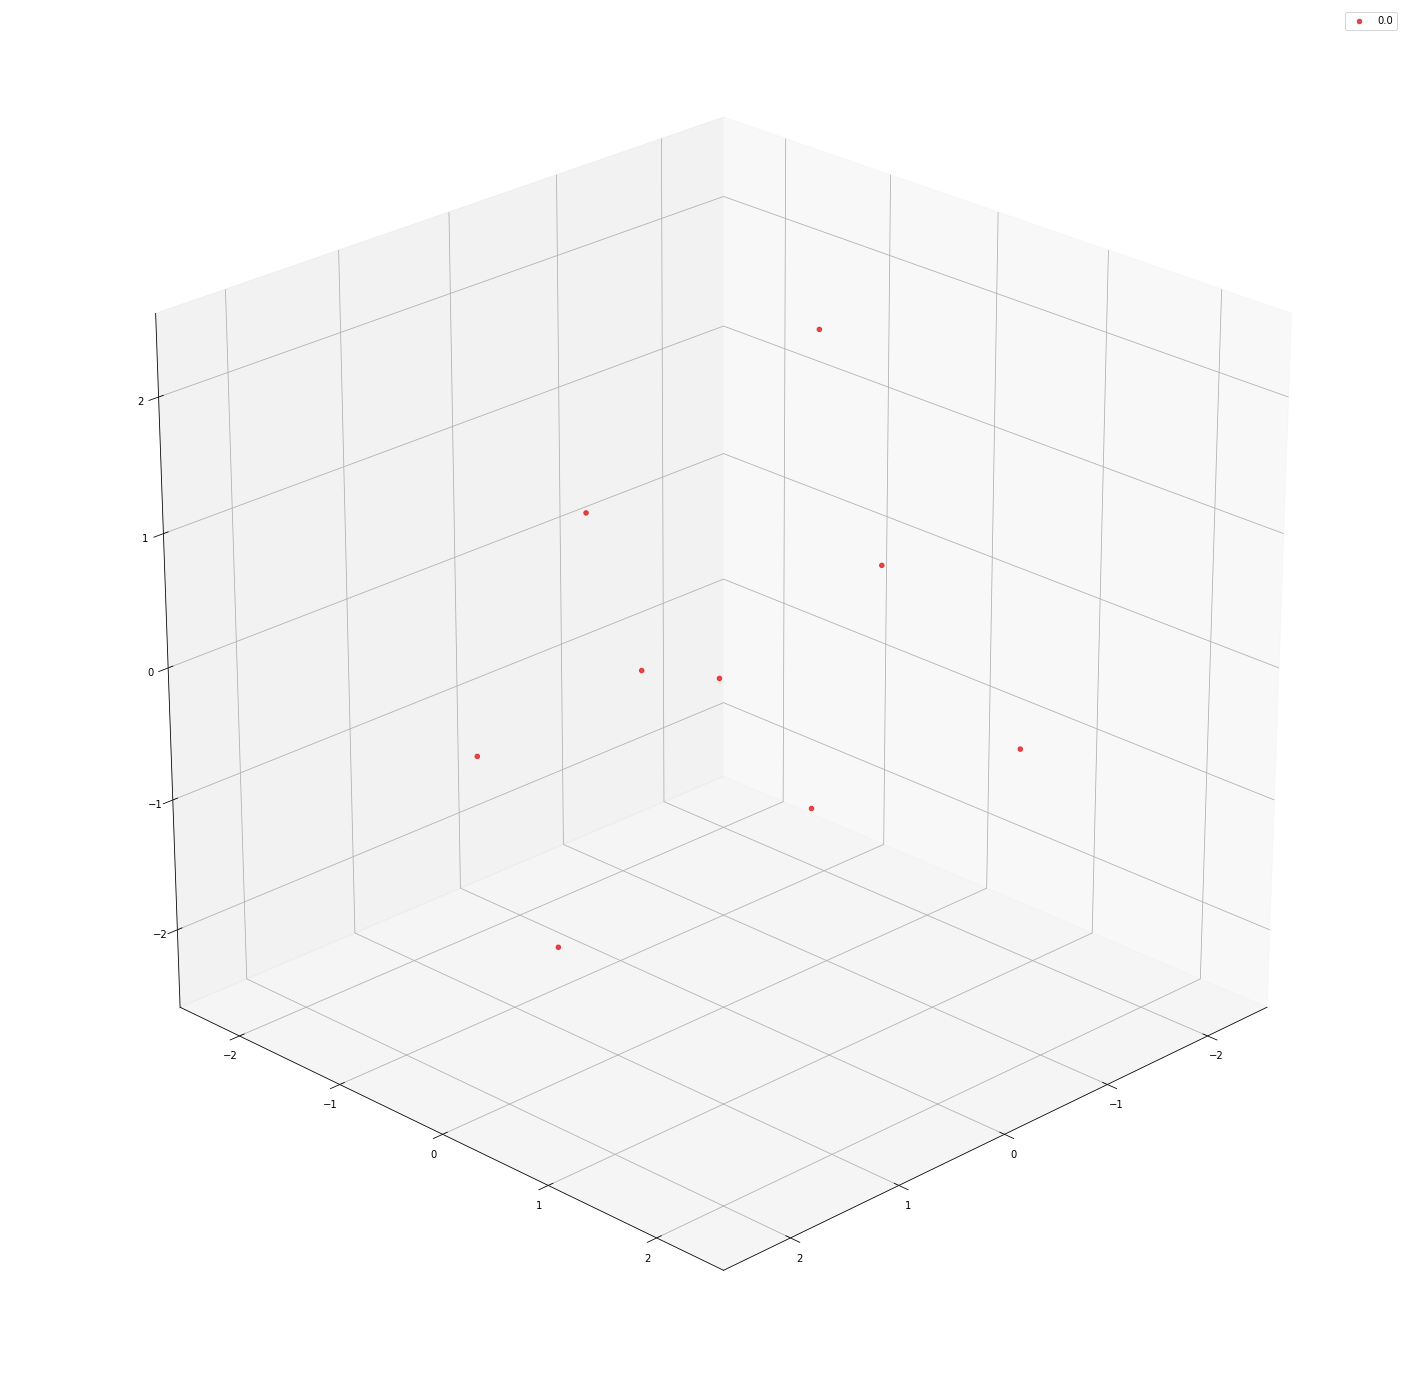

In [114]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111,projection='3d')

plt.grid()
    
nb_classes = len(np.unique(label_ids))
    
for label_id in np.unique(label_ids):
    ax.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                tsne_result_scaled[np.where(label_ids == label_id), 2],
                alpha=0.8,
                color= plt.cm.Set1(label_id / float(nb_classes)),
                marker='o',
                label=id_to_label_dict[label_id])
ax.legend(loc='best')
ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

In [0]:
anim = animation.FuncAnimation(fig, lambda frame_number: ax.view_init(30, 4 * frame_number), interval=75, frames=90)

In [116]:
plot_3d_animation_filename = 'animation.gif'
anim.save(plot_3d_animation_filename, writer='imagemagick')

MovieWriter imagemagick unavailable. Trying to use pillow instead.


In [0]:
import io
import base64
from IPython.display import HTML

video = io.open(plot_3d_animation_filename, 'r+b').read()

In [0]:
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(base64.b64encode(video).decode('ascii')))